# 01 — Explore Data
This notebook does a quick EDA of `data/raw/artifacts.csv` and `data/raw/controls.csv`.

In [1]:

import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ART_PATH = Path('../data/raw/artifacts.csv')
CTRL_PATH = Path('../data/raw/controls.csv')

assert ART_PATH.exists(), f"Missing {ART_PATH}"
assert CTRL_PATH.exists(), f"Missing {CTRL_PATH}"

art = pd.read_csv(ART_PATH)
ctrl = pd.read_csv(CTRL_PATH)

display(art.head(10))
display(ctrl.head(10))

print("Artifacts shape:", art.shape)
print("Controls shape:", ctrl.shape)


,artifact_id,text,evidence_type,timestamp,gold_controls,split,gold_rationale
0,1,Service account svc-app used interactively; no...,log,2025-03-15T14:22:12Z,AC-2;AC-6,train,Account management and least privilege issues ...
1,2,Asset inventory lacks serverless functions and...,policy,2025-09-01T20:08:18Z,CM-8,train,Inventory incomplete ⇒ CM-8.
2,3,Missing monthly patching; critical CVEs outsta...,policy,2025-08-22T21:26:32Z,SI-2;RA-5,test,Flaw remediation cadence insufficient; ties to...
3,4,SIEM review missed for 30 days; high severity ...,config,2025-06-10T07:10:20Z,AU-6;SI-4,test,Audit analysis cadence insufficient; monitorin...
4,5,Code repo org/payments contains committed secr...,ticket,2025-06-10T01:45:31Z,SA-11;IA-5;SI-7,train,Developer testing and secret management gaps ⇒...
5,6,Endpoint AV disabled on siem-01; malware signa...,log,2025-08-21T08:18:18Z,SI-3,train,Malicious code protection ineffective ⇒ SI-3.
6,7,Asset inventory lacks serverless functions and...,log,2025-09-10T12:50:16Z,CM-8,train,Inventory incomplete ⇒ CM-8.
7,8,Weekly vuln scan skipped on app-01; unauthenti...,ticket,2025-09-27T03:29:18Z,RA-5;SI-2,train,Scanning cadence and patching follow-up lackin...
8,9,API gateway rate limiting disabled; prior DDoS...,log,2025-07-27T07:49:22Z,SC-5;SC-7,train,DoS protection missing; boundary controls impl...
9,10,File integrity monitoring not deployed on prox...,log,2025-10-07T23:13:55Z,SI-7;SI-4,train,Integrity monitoring absent; monitoring contex...


,control_id,family,title,summary
0,AC-17,AC,Remote Access,"Authorize, monitor, and control remote/VPN acc..."
1,AC-18,AC,Wireless Access,Manage and secure wireless APs/clients; requir...
2,AC-2,AC,Account Management,"Create, modify, disable, and remove accounts; ..."
3,AC-6,AC,Least Privilege,Restrict privileges to the minimum necessary; ...
4,AC-7,AC,Unsuccessful Logon Attempts,Enforce lockout/backoff after a defined number...
5,AU-12,AU,Audit Generation,Ensure applications/components generate audit ...
6,AU-2,AU,Event Logging,Define auditable events and ensure systems gen...
7,AU-3,AU,Content of Audit Records,"Include timestamp, user, source, and event det..."
8,AU-6,AU,"Audit Review, Analysis, and Reporting",Regularly review and analyze logs; correlate a...
9,AU-8,AU,Time Synchronization,Synchronize clocks to an authoritative source ...


Artifacts shape: (1240, 7)
Controls shape: (31, 4)


# Label counts (by control family)

,count
family,
AC,275
AU,383
CM,222
CP,50
IA,269
IR,94
RA,90
SA,114
SC,415


,count
cid,
AC-17,50
AC-18,57
AC-2,62
AC-6,62
AC-7,44
AU-12,104
AU-2,51
AU-3,53
AU-6,103


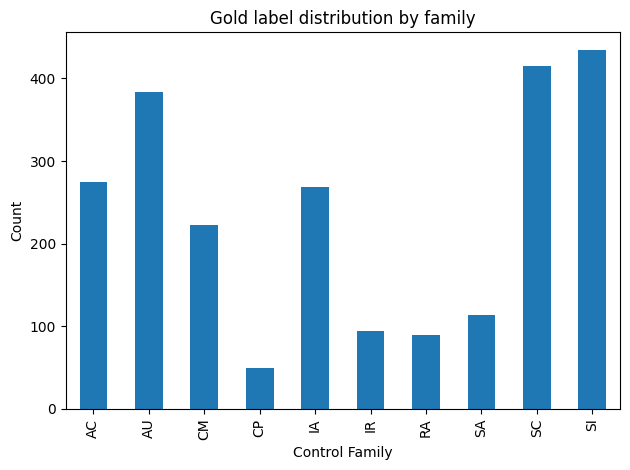

In [2]:

cid2fam = dict(zip(ctrl['control_id'], ctrl['family']))
rows = []
for _, r in art.iterrows():
    for cid in str(r['gold_controls']).split(';'):
        cid = cid.strip()
        if not cid:
            continue
        rows.append({'family': cid2fam.get(cid, 'UNK'), 'cid': cid})
lab = pd.DataFrame(rows)
fam_counts = lab['family'].value_counts().sort_index()
cid_counts = lab['cid'].value_counts().sort_index()
display(fam_counts.to_frame('count'))
display(cid_counts.to_frame('count'))

plt.figure()
fam_counts.plot(kind='bar')
plt.title('Gold label distribution by family')
plt.xlabel('Control Family')
plt.ylabel('Count')
plt.tight_layout()


# Evidence type and split summary

evidence_type,config,log,policy,ticket
split,,,,
test,58,58,53,71
train,252,252,257,239


<Figure size 640x480 with 0 Axes>

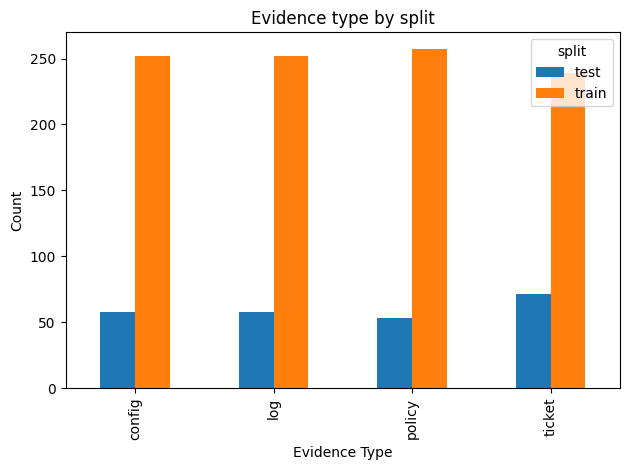

In [3]:

etype_counts = art.groupby(['split','evidence_type']).size().unstack(fill_value=0)
display(etype_counts)

plt.figure()
etype_counts.T.plot(kind='bar')
plt.title('Evidence type by split')
plt.xlabel('Evidence Type')
plt.ylabel('Count')
plt.tight_layout()


# Text length distribution

count    1240.000000
mean       10.433065
std         1.098258
min         8.000000
25%        10.000000
50%        10.000000
75%        11.000000
max        14.000000
Name: text, dtype: float64


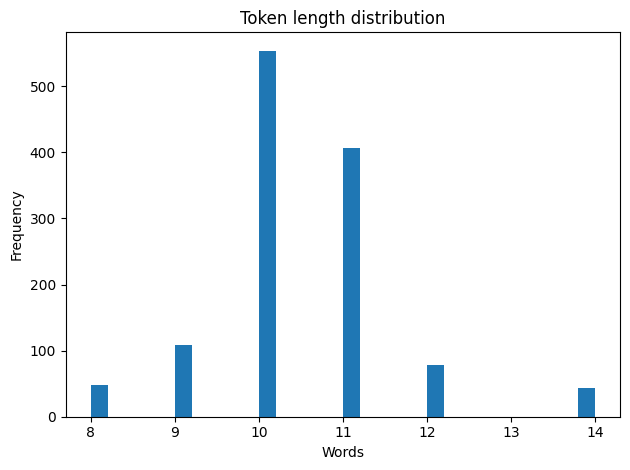

In [4]:

text_len = art['text'].fillna('').map(lambda s: len(s.split()))
print(text_len.describe())

plt.figure()
text_len.plot(kind='hist', bins=30)
plt.title('Token length distribution')
plt.xlabel('Words')
plt.tight_layout()
